Pipeline Draft

There are three types of tags in this assignment:
<br>
1) Weather (Cloudly, Partly Cloudy, Hazy, Clear) - every item has only one of these ones
<br>
2) Easy to identify tags Primary (forest), agricultural, habitation, roads, water, cultivation, bare ground,
<br>
3) Hard Labels - Slash & Burn, selective logging, blooms, and mine types
<br>

For the base submission we will try to classify the first and second types and leave hard labels to the full sub,ission

Overview of summary:
1) Exploratory Data Analysis - Elle/Wei
<br>
2) Image Processing and Extraction - Elle/Sai
<br>
3) Weather Prediction Attempts- Wei
<br>
3) Land Type Prediction Attempts Nick/Sai
<br>
4) Try CNNs (this is for stage 2)

5) Build a clean pipe-line per June's comment - Nick
<br>
Take the time in the beginning to make it easy to swap in and out models. This can be done a few ways. Either with helper functions inside a main notebook, or by breaking the project up into stages of pre-processing, ship the pre-processed data to each of the models, then the models ship back the predictions to a final step. But have a think through in the beginning how to set this up so that folks can simultaneously work on different models at the same time.

<br>



In [1]:
##Create Libraries
### Required libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from subprocess import check_output
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import bernoulli
import seaborn as sns
import cv2
# from osgeo import gdal
from skimage import io
from spectral import get_rgb
from spectral import ndvi
from sklearn import preprocessing
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from skimage import transform
from sklearn.tree import DecisionTreeClassifier



C:\Users\Elle\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Elle\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
##set directories path
train_path1='train_jpg/'
train_path2='train_tif/'
test_path1='test_jpg/'
print(test_path1)
df = pd.read_csv('train_labels.csv')

test_jpg/


EDA
1) Things to do show variety of images (Done - Elle)
<br>
2) Show the size of the seth
<br>
2) Show volume of labels (Done - Elle) in a graph form
<br>
3) Show Correlation between Labels (Wei)
<br>
4) Create Secondary sets of labels with only easy labels, and only weather labels - Elle Done
<br>

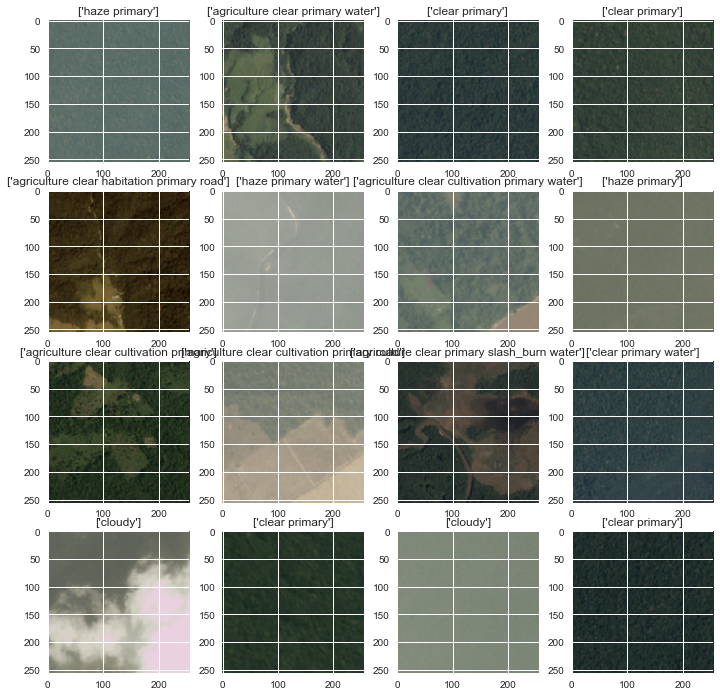

In [4]:
plt.figure(figsize=(12,12))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(plt.imread(train_path1+'train_'+str(i)+'.jpg'))
    plt.title(str(df[df.image_name == 'train_'+str(i)].tags.values))

total of 116278 non-unique tags in all training images
average number of labels per image 2.8725511993873365 

There is 17 unique labels including {'artisinal_mine', 'cloudy', 'bare_ground', 'slash_burn', 'conventional_mine', 'clear', 'partly_cloudy', 'agriculture', 'cultivation', 'water', 'blooming', 'habitation', 'selective_logging', 'blow_down', 'primary', 'haze', 'road'} 



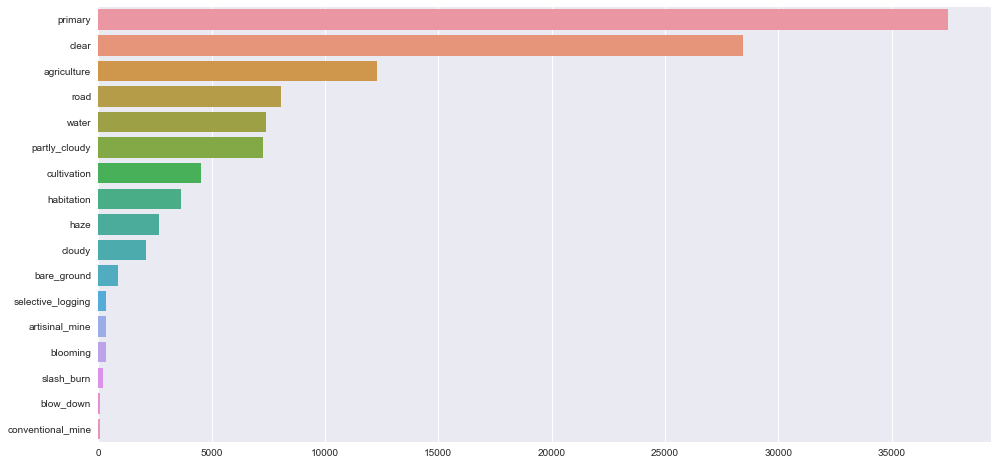

In [5]:
## View prominent tags and investigate correlations

df = pd.read_csv('train_labels.csv')

all_tags = [item for sublist in list(df['tags'].apply(lambda row: row.split(" ")).values) for item in sublist]


print('total of {} non-unique tags in all training images'.format(len(all_tags)))
print('average number of labels per image {} \n'.format(1.0*len(all_tags)/df.shape[0]))

labels_set = set(all_tags)
print("There is {} unique labels including {} \n".format(len(labels_set), labels_set))

labels_s = pd.Series(all_tags).value_counts() # To sort them by count
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=labels_s, y=labels_s.index, orient='h')

In [6]:
##Simplify Problems
##Separate weather tags
def apply_weather(weather):
    if 'partly_cloudy' in weather:
        return 'partly_cloudy'
    elif 'cloudy' in weather:
        return 'cloudy'
    elif 'haze' in weather:
        return 'haze'
    else:
        return 'clear'
df['weather'] = df.tags.map(apply_weather)


df_tags = df['weather'].tolist()
##Separate weather tags
test_labels=np.array(df_tags[15000:20000])
train_labels=np.array(df_tags[:15000])

def remove_tag(hard):
    hard_tags=['blow_down', 'conventional_mine', 'selective_logging', 'slash_burn', 'artisinal_mine', 'blooming']
    easier_tags=hard.split()
    for i in hard_tags:
        try:
            easier_tags.remove(i)
        except:
            pass
    easier_tags=' '.join(easier_tags)
    return easier_tags
df['simpler_tags'] = df.tags.map(remove_tag)

test_labels=np.array(df_tags[15000:20000])
train_labels=np.array(df_tags[:15000])

Image Processing for weather prediction:
1) Work out how to reduce image sizes - everybody ()
<br>
2) Move, Shape, Blend, Rotate
<br>
3) Try Statistical Extraction 
Maybe this is a good approach to extract stats - we can add our road information into it:
https://www.kaggle.com/the1owl/fractals-of-nature-blend-0-90050
<br>
<br>
<br>
4) Try Feature Extraction :
<br>
Roads/ Houses via Canny edging - Sai
Water and Vegetation - Elle
Cloud - Elle
Haze removal - Elle


Now - let's look at the TIF images, which also contain infrared information. 
This is helpful because it contains infrared light which helps us identify 
Essentially we can tell if something is likely to be water by substracting the 
infrared light from the blue light, and dividing by sum.

The same can be said for vegetation. 

The two formulas are
(B-IRR)/(B+IRR) = index for water
(R-IRR)/(R+IRR) = index for vegetation

In [44]:
np.seterr(all='warn')
def extract_identifier(image_str):
    read_img = io.imread(train_path2+image_str)
    tif_img=transform.resize(read_img, (64,64,4))
    return tif_img

tif_data=np.zeros((40000,64,64,4))
for i in range(40000):
    tif_data[i,:,:,:]=extract_identifier("train_"+str(i)+".tif")

water_tif=(tif_data[:,:,:,0]-tif_data[:,:,:,3])/(tif_data[:,:,:,0]+tif_data[:,:,:,3])
veg_tif=(tif_data[:,:,:,3]-tif_data[:,:,:,2])/(tif_data[:,:,:,3]+tif_data[:,:,:,2]) 
new_tif= tif_data.reshape(40000,16384)
plt.imshow(water_tif[18573])
plt.imshow(veg_tif[18573])

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000


In [ ]:
##extract Variation statistics from trees
land_props=np.zeros((40000,50))
for i in range(40000):
    land_props[i,:]=np.array(np.histogram(veg_tif[i],bins=50, range=(-1,1))[0])
water_props=np.zeros((40000,50))
for i in range(40000):
    water_props[i,:]=np.array(np.histogram(water_tif[i],bins=50, range=(-1,1))[0])
print(water_props)
combined_matrix=np.zeros((40000,100))
combined_matrix[:,0:50]=land_props
combined_matrix[:,50:100]=water_props

In [213]:
print(tif_data[1].shape)



(64, 64, 4)


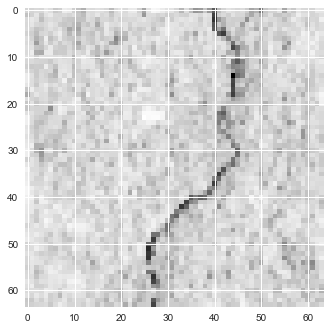

In [226]:
##read weather J-pegs
weather_jpgs=np.zeros((40000,64,64,3))
def read_image(image_str):
    read_img = plt.imread(train_path1+image_str)
    read_img=read_img[:,:,:3]
    jpg_img=transform.resize(read_img, (64,64,3))
    return jpg_img
for i in range(40000):
    weather_jpgs[i,:,:,:]=read_image("train_"+str(i)+".jpg")
    if i % 100 ==0:
        print(i)


0
100
200
300
400
500
600
700
800
900


In [242]:
##extract_basic-stats
stats_flat=np.reshape(weather_jpgs,(weather_jpgs.shape[0],4096,3))
jpg_stats=np.zeros((stats_flat.shape[0],9))
for i in range(stats_flat.shape[0]):
    jpg_stats[i,0:3]=np.average(weather_flat[i],axis=0)
    jpg_stats[i,3:6]=np.var(weather_flat[i],axis=0)
    jpg_stats[i,3:9]=np.std(weather_flat[i],axis=0)
    
matrix_for_analysis=np.zeros((40000,109))
matrix_for_analysis[40000,:100]=combined_matrix
matrix_for_analysis[40000,100:]=jpg_stats

3) Try these models (this needs to be on the processed numbers) - Sai/Nick
OneVsRestClassifier
https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Multi%20label%20text%20classification.ipynb

K-NN
Naive Bayes
Decision Trees
Random forests
Logistic Regression
Binary Relevance Chain 
Gaussian NB
Logsitic Regression

K-NN
Naive Bayes
Decision Trees
Random forests
Logistic Regression

Classifier CHains 
Gaussian NB
Logsitic Regression

K-NN
Naive Bayes
Decision Trees
Random forests
Logistic Regression
Adapted Algorithms
Multi-label nearest Neigbors
Decisions Trees
Random Forests
Neural Nets



Image Processing - how do we make the images smaller, easier size agnostic

In [191]:
Weather Models

test_labels=df_tags[15000:20000]
train_labels=df_tags[:15000]
train_data=water_shape[:15000]
test_data=water_shape[15000:20000]

##Model Prediction - run variety of models to identify weather, using model extraction - run a bunch of models here. 
##Work out how better to separate partly cloudy - perhaps a count for cloudy pixels

def dec_tree_model(maxs,data_train,labels_train,data_test,labels_test):
    #set the model to take in the k value
    model = DecisionTreeClassifier(min_samples_leaf=10, max_depth=maxs)
    #fit per the train data
    model.fit(data_train, labels_train)
    dev_predictions2=model.predict(data_test)
    #set by the test data
#     score = model.score(data_test, labels_test)
    #print the score prettily
    return classification_report(labels_test,dev_predictions2)

#print eveyrhting
print("dev data sets")
for i in [5,10,20,50,100]:
    print(dec_tree_model(i,train_data,train_labels,test_data,test_labels))

In [193]:
def k_model(k,data_train,labels_train,data_test,labels_test):
    #set the model to take in the k value
    model = KNeighborsClassifier(n_neighbors=k)
    #fit per the train data
    model.fit(data_train, labels_train)
    #set by the test data
    score = model.score(data_test, labels_test)
    #print the score prettily
    return (str(k)+"-NN model score: "+	str("{:.2%}".format(score)))

k_values = [1, 3]

#print eveyrhting
print("dev data sets")
for k in k_values:
    print(k_model(k,train_data,train_labels,test_data,test_labels))

dev data sets


KeyboardInterrupt: 

In [192]:
def dec_tree_model(maxs,data_train,labels_train,data_test,labels_test):
    #set the model to take in the k value
    model = DecisionTreeClassifier(min_samples_leaf=10, max_depth=maxs)
    #fit per the train data
    model.fit(data_train, labels_train)
    dev_predictions2=model.predict(data_test)
    #set by the test data
#     score = model.score(data_test, labels_test)
    #print the score prettily
    return classification_report(labels_test,dev_predictions2)

for i in [5,10,20,50]:
    print(dec_tree_model(i,train_data,train_labels,test_data,test_labels))

C:\Users\Elle\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


               precision    recall  f1-score   support

        clear       0.75      0.91      0.82      3517
       cloudy       0.28      0.69      0.40       241
         haze       0.00      0.00      0.00       347
partly_cloudy       0.37      0.08      0.13       895

  avg / total       0.61      0.68      0.62      5000

               precision    recall  f1-score   support

        clear       0.77      0.84      0.80      3517
       cloudy       0.35      0.58      0.44       241
         haze       0.32      0.18      0.23       347
partly_cloudy       0.33      0.21      0.26       895

  avg / total       0.64      0.67      0.65      5000

               precision    recall  f1-score   support

        clear       0.77      0.82      0.79      3517
       cloudy       0.42      0.52      0.46       241
         haze       0.32      0.18      0.23       347
partly_cloudy       0.30      0.25      0.27       895

  avg / total       0.64      0.66      0.65      5000

 

Out of scope
Try Convultional Neural Networks
Ask June for help in Set-up